In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc

import keras as k
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import cv2
from tqdm import tqdm

from multiprocessing import Pool, cpu_count

from subprocess import check_output
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score
from keras.callbacks import LambdaCallback, EarlyStopping
from keras.models import load_model
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import keras.backend as K
%matplotlib inline

In [2]:
df_train = pd.read_csv('inputs/train_v2.csv')
print("Number of records in Training set %d" % len(df_train))
df_train.head(2)

Number of records in Training set 40479


image_name                             tags
0    train_0                     haze primary
1    train_1  agriculture clear primary water

In [3]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}
print(labels)

['slash_burn', 'clear', 'blooming', 'primary', 'cloudy', 'conventional_mine', 'water', 'haze', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'habitation', 'bare_ground', 'blow_down', 'agriculture', 'road', 'selective_logging']


In [11]:
input_dir = 'inputs'
img_size = 128

X = []
Y = []
for f, tags in tqdm(df_train.values, miniters=1000):
    f_name = '{}.jpg'.format(f)
#     print(os.path.join(input_dir, 'train-jpg', f_name))
    img = cv2.imread(os.path.join(input_dir, 'train-jpg', f_name))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    X.append(cv2.resize(img, (img_size, img_size)))
    Y.append(targets)

X = np.array(X, np.float16) / 255.
Y = np.array(Y, np.uint8)

print(X.shape)
print(Y.shape)

100%|██████████| 40479/40479 [00:33<00:00, 1193.63it/s]


(40479, 128, 128, 3)
(40479, 17)


In [12]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.2, random_state=0)

In [6]:
model = load_model('models/best/starter1_128_9155.h5')

In [43]:
# del model
# K.clear_session()

In [14]:
def get_scores_per_class(Y_valid, p_valid):
    spc = []
    for i in range(17):
        spc.append(fbeta_score(Y_valid[:,i], (p_valid[:,i] > 0.2).astype(int), beta=2))
    return spc

In [17]:
p_valid = model.predict(X_valid, batch_size=256, verbose=2)
print("Average score %f" % fbeta_score(Y_valid, (p_valid > 0.2).astype(int), beta=2, average='samples'))
scores = get_scores_per_class(Y_valid, p_valid)
df_scores = pd.DataFrame(index=range(len(labels)), columns=['label', 'max_score'])
for i in inv_label_map:
    df_scores.label[i] = inv_label_map[i]
    df_scores.max_score[i] = scores[i]
df_scores

Average score 0.915595


label max_score
0          slash_burn         0
1               clear  0.976372
2            blooming  0.212766
3             primary  0.989903
4              cloudy   0.87572
5   conventional_mine         0
6               water  0.757837
7                haze  0.759429
8         cultivation  0.655598
9       partly_cloudy  0.927814
10     artisinal_mine  0.754438
11         habitation  0.718501
12        bare_ground   0.14742
13          blow_down         0
14        agriculture  0.875147
15               road  0.847246
16  selective_logging  0.411622

In [19]:
# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(history_callback.history['loss'])
# plt.plot(history_callback.history['val_loss'])
# plt.legend(labels=['loss', 'val_loss'])
# plt.subplot(1, 2, 2)
# plt.plot(scores)
# plt.legend(labels=['val_fbeta'])
# # plt.show()

In [20]:
def find_ratios(y_true, y_pred, num_classes=2):
    scores = np.zeros(num_classes)
    rat = np.zeros(num_classes)
    step = 0.05
    n = int(1/step)
    for j in range(num_classes):
        r = step
        for i in range(n):
            score = fbeta_score(y_true[:,j], (y_pred[:,j] > r).astype(int), beta=2)
            if score > scores[j]:
                scores[j] = score
                rat[j] = r
            r+=step
    rat[rat == 0] = step
    return rat

In [21]:
# p_valid = model.predict(X_valid, batch_size=batch_size,verbose=2)
# rat = find_ratios(Y_valid, p_valid)
# rat

In [44]:
def plot_confusion_matrix_for_tag(tag):
    column=label_map[tag]
    # cm = confusion_matrix(y_target=Y_valid[:,column], y_predicted=pred, binary=False)
    cm = confusion_matrix(y_target=Y_valid[:,column], y_predicted=(p_valid[:,column].squeeze() > 0.2).astype(int), binary=False)
    _, ax = plot_confusion_matrix(conf_mat=cm)
    ax.set_title(inv_label_map[column])
    plt.show()

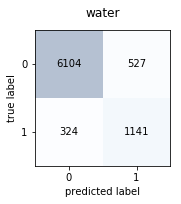

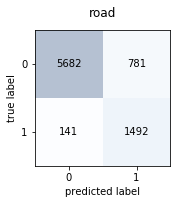

In [46]:
plot_confusion_matrix_for_tag('water')
plot_confusion_matrix_for_tag('road')

In [26]:
p_valid_ = (p_valid[:,column] > 0.2).astype(int)
Y_valid_ = Y_valid[:,column]

In [27]:
tp = X_valid[(p_valid_ == Y_valid_) & (p_valid_ == 1)]
tn = X_valid[(p_valid_ == Y_valid_) & (p_valid_ == 0)]
fp = X_valid[(p_valid_ != Y_valid_) & (p_valid_ == 1)]
fn = X_valid[(p_valid_ != Y_valid_) & (p_valid_ == 0)]
print(tp.shape)
print(tn.shape)
print(fp.shape)
print(fn.shape)

(1492, 128, 128, 3)
(5682, 128, 128, 3)
(781, 128, 128, 3)
(141, 128, 128, 3)


In [28]:
def show_examples(data, num, cols = 4, zoom=2):
    import math
    from matplotlib.pyplot import imshow
    rows = int(math.ceil(num/cols))
    _, ax = plt.subplots(rows, cols, figsize=(cols*zoom, rows*zoom))
    for i in range(num):
        if len(ax.shape) > 1:
            ax[i // cols, i % cols].imshow((255*data[i]).astype(np.uint8))
        else:
            ax[i].imshow((255*data[i]).astype(np.uint8))

True positives


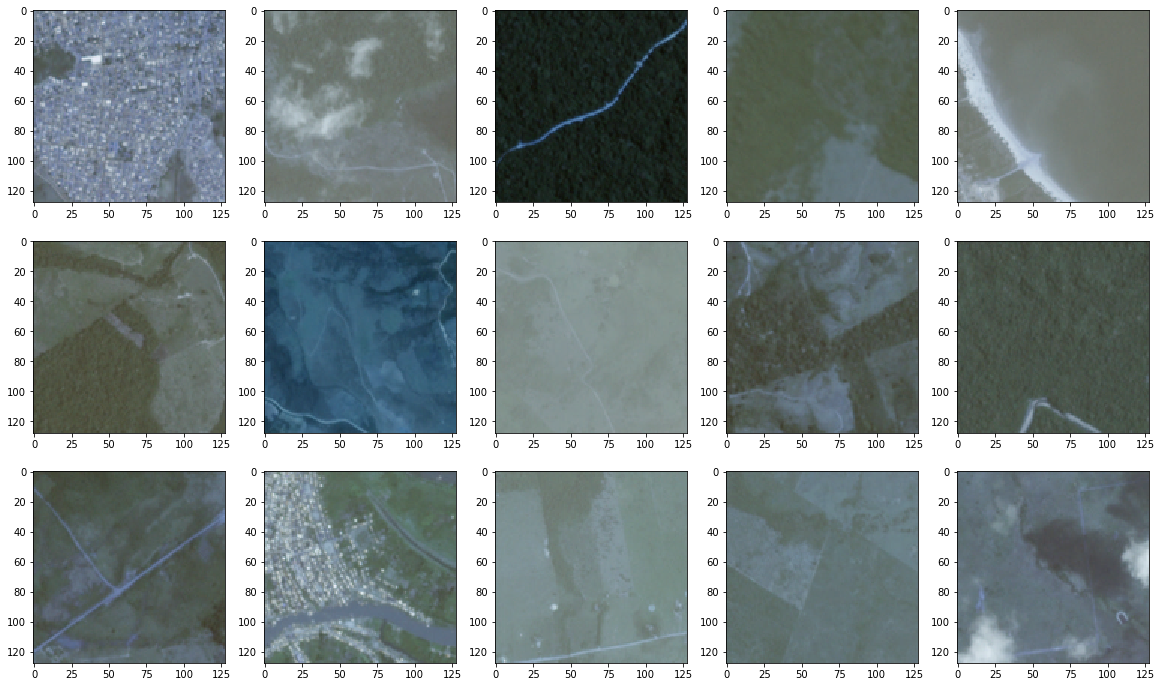

In [35]:
print("True positives")
show_examples(tp, 15, cols=5, zoom=4)

True negative


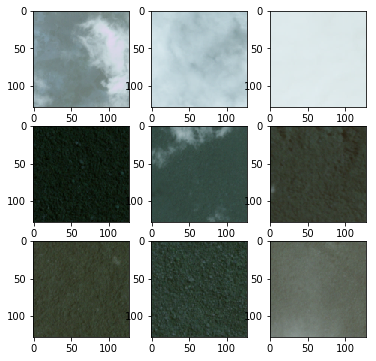

In [31]:
print("True negative")
show_examples(tn, 9, cols=3, zoom=2)

False positives


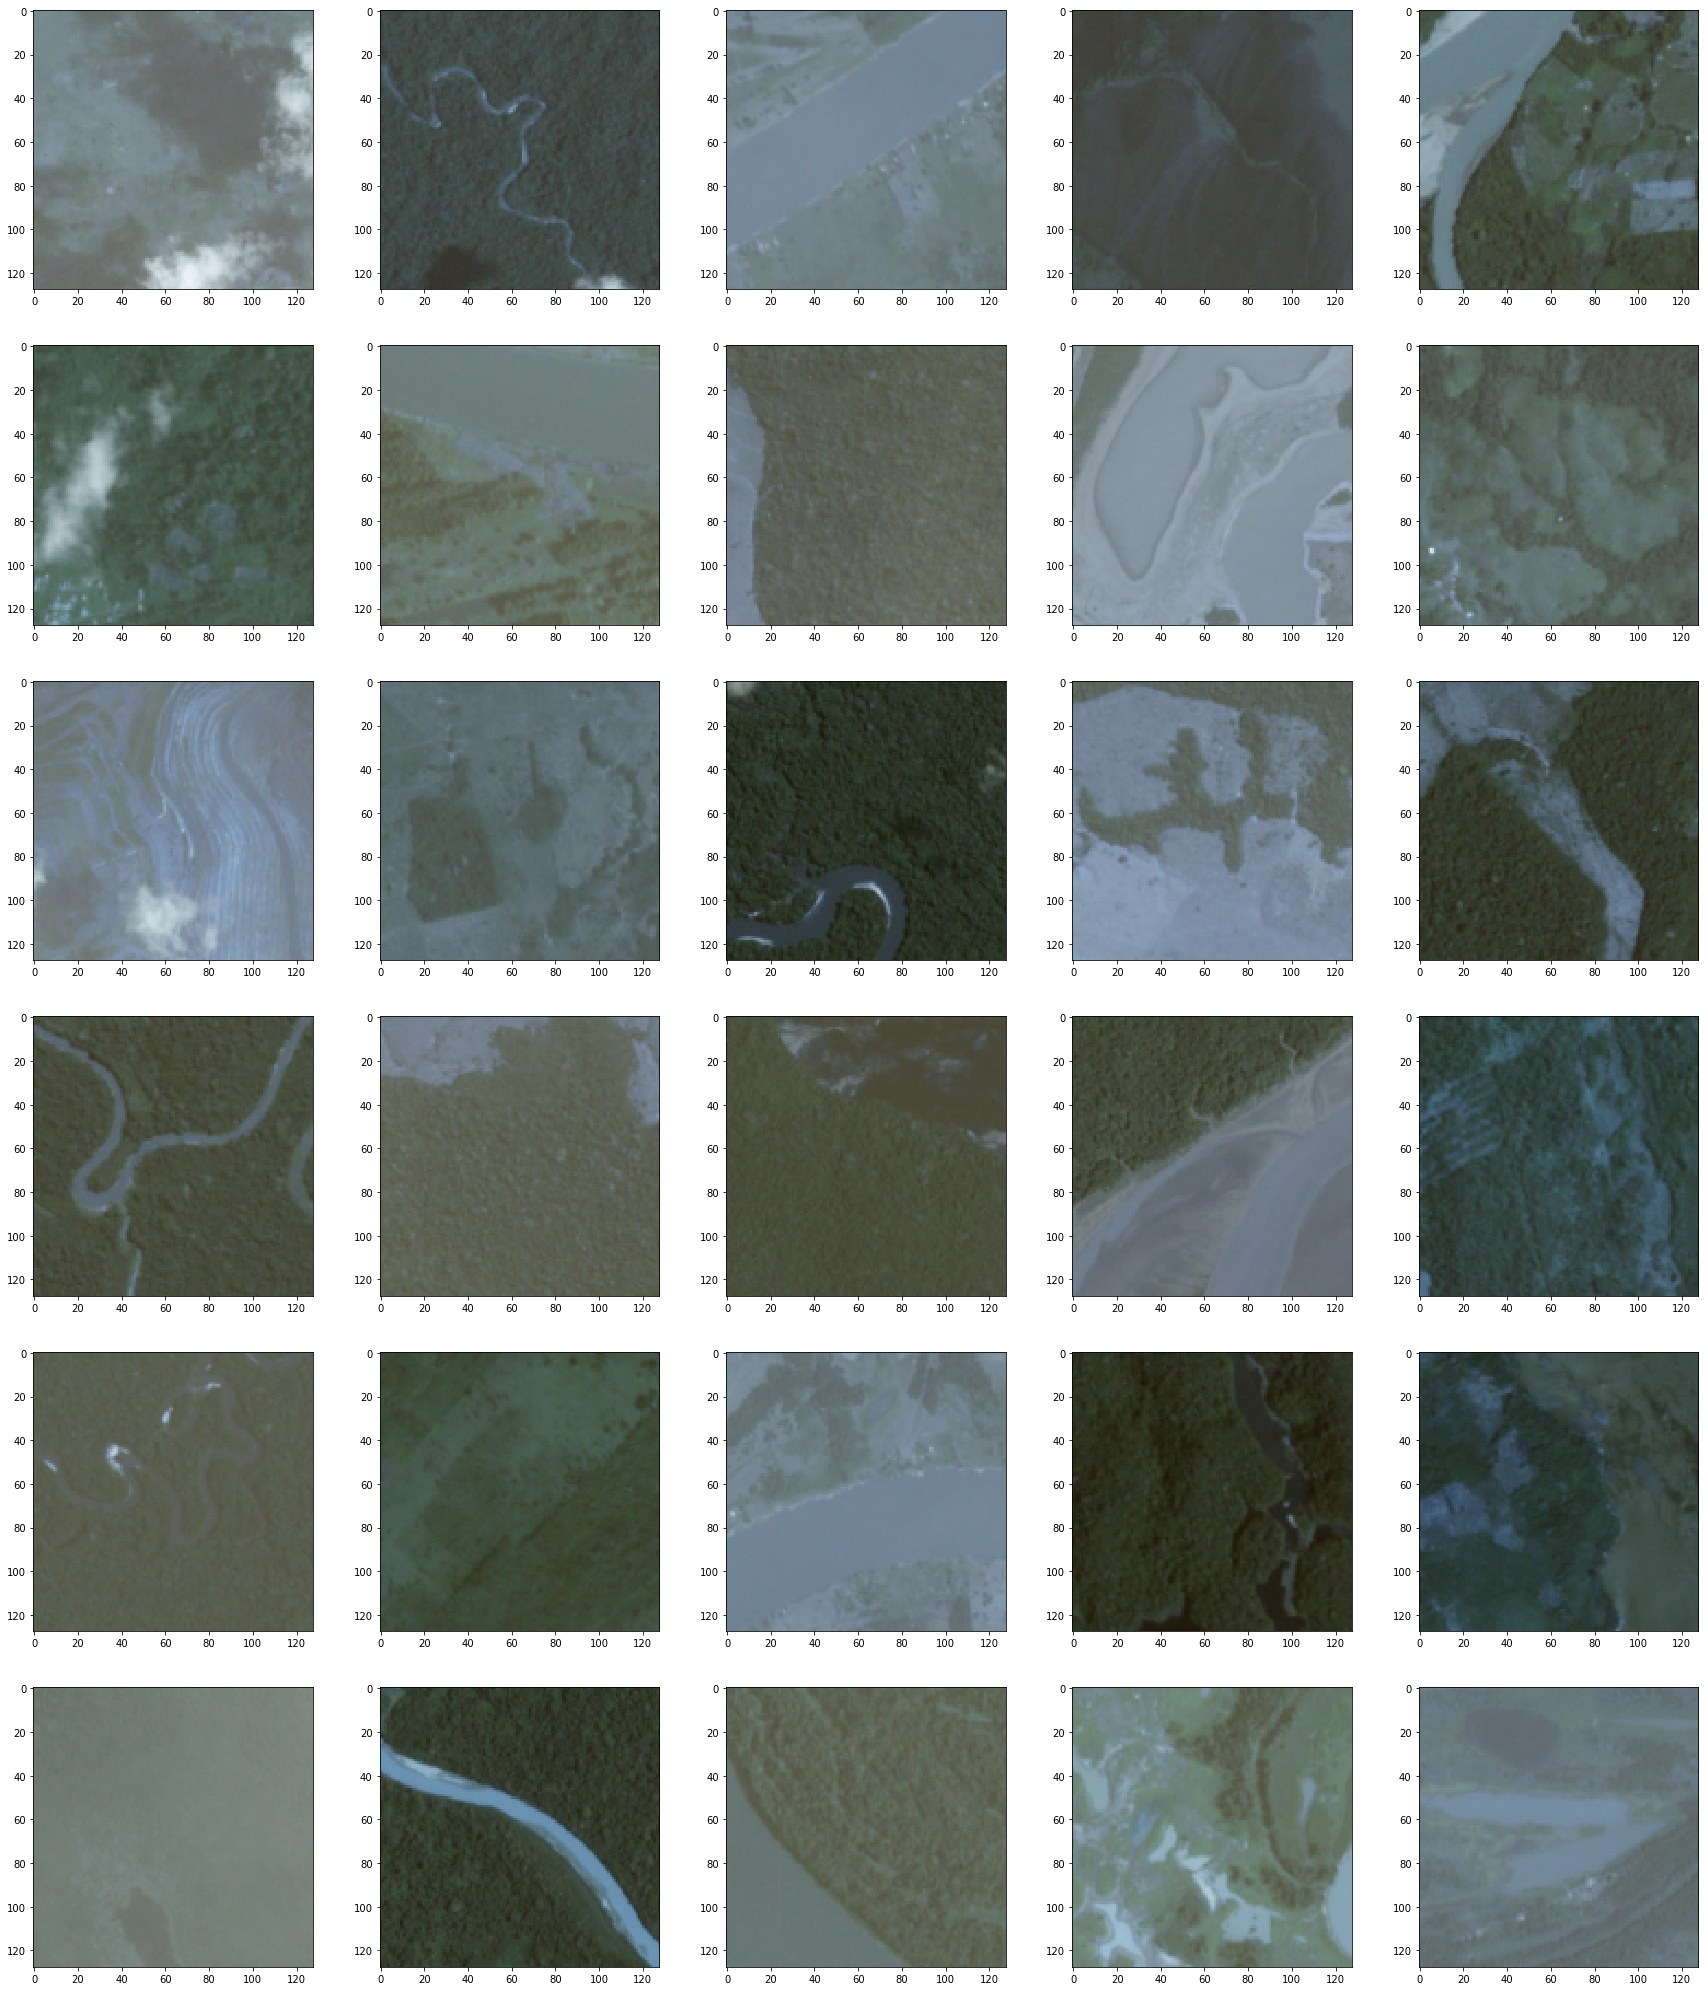

In [34]:
print("False positives")
show_examples(fp, 30, cols=5, zoom=6)

False negative


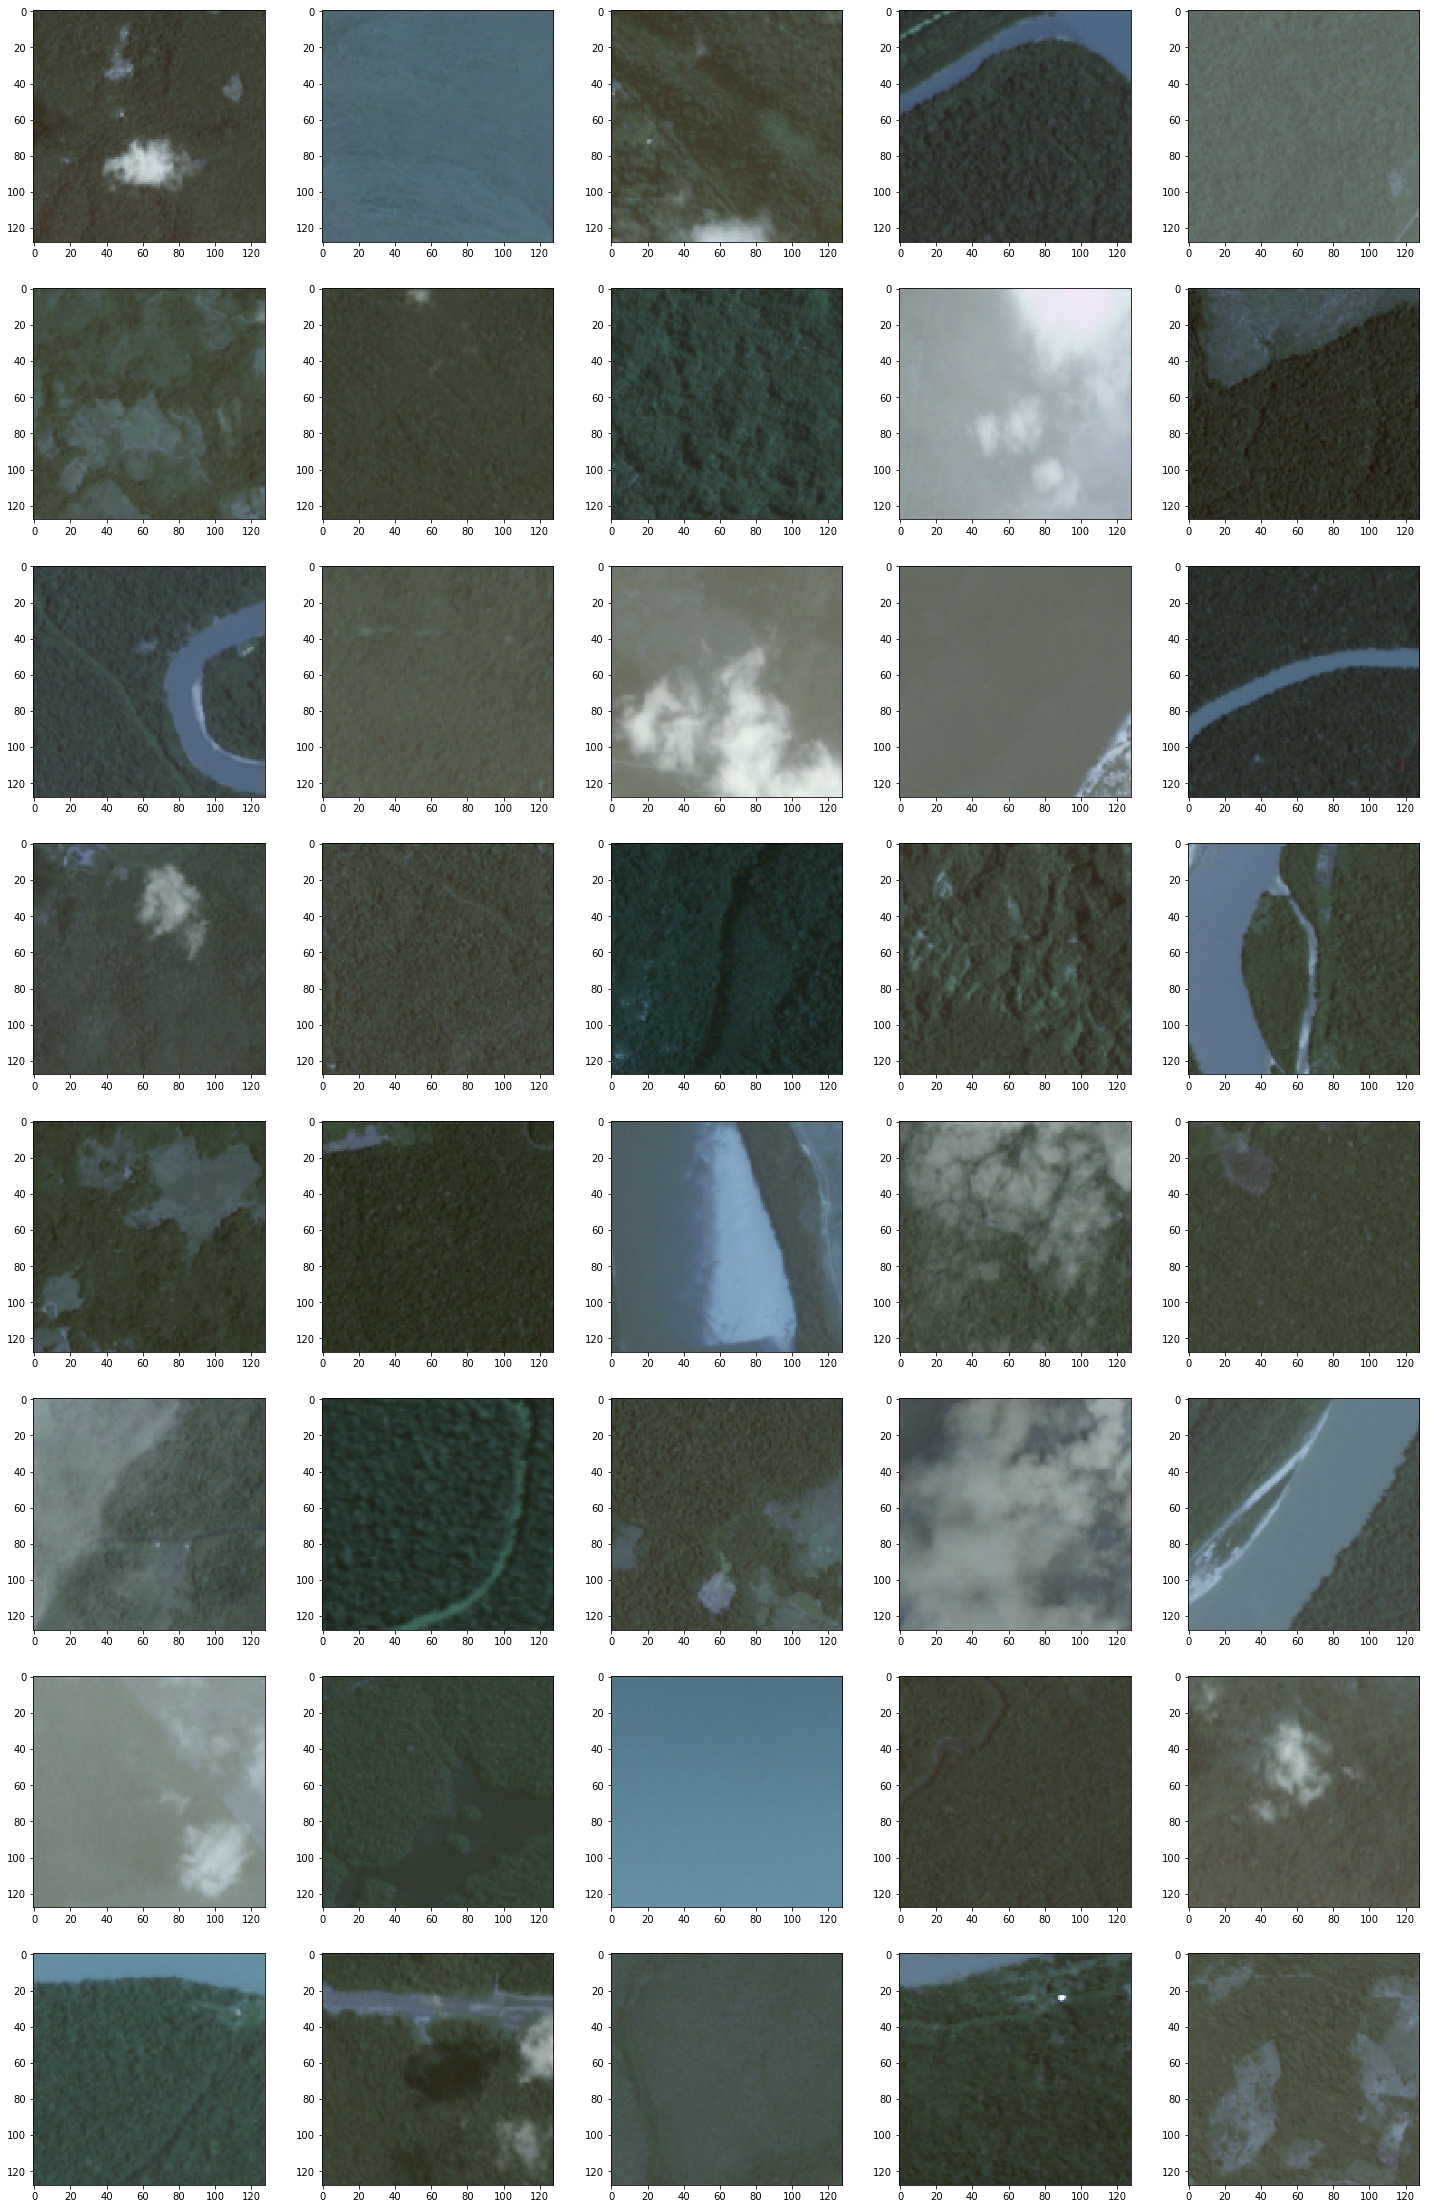

In [37]:
print("False negative")
show_examples(fn, 40, cols=5, zoom=5)